In [1]:
from sklearn.datasets import make_classification
from torch import nn, optim
from skorch import NeuralNetClassifier
import numpy  as np
# sys.path.append('./pyperch')
# from pyperch.neural.backprop_nn import BackpropModule
import matplotlib.pyplot as plt
import torch
import random
from ucimlrepo import fetch_ucirepo
from sklearn.metrics import accuracy_score, make_scorer, f1_score, confusion_matrix, log_loss

import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from pipelines import KMeans_pipeline, TSNE_pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import helpers
import importlib
import pipelines
import pipeline_helpers
import seaborn as sns
from scipy.stats import kurtosis
from notebook_helper import reload_notebook_cell, generate_seed
from sklearn.model_selection import KFold


## Get Data

In [2]:

from generate_data import get_and_preprocess_sdas_data, get_and_preprocess_sdas_data, y_label_encode, CATEGORY_COLUMNS_UCML
from sklearn.preprocessing import  LabelEncoder
reload_notebook_cell()

X_train_sdas, X_test_sdas, y_train_sdas, y_test_sdas = get_and_preprocess_sdas_data()

# Initialize and fit LabelEncoder
y_train_encoded_sdas, y_test_encoded_sdas, label_encoder_sdas = y_label_encode(y_train_sdas,y_test_sdas)
y_train_encode_sdas, y_test_encode_sdas, label_encoder_sdas = y_label_encode(y_train_sdas, y_test_sdas)

# get data to correct type for NN
y_train_encoded_sdas = y_train_encoded_sdas.astype(np.int64)
y_train_encode_sdas = y_train_encode_sdas.astype(np.int64)

cv = KFold(n_splits=4, shuffle=False)

Removed columns: ["encoding__Mother's qualification_18", "encoding__Mother's qualification_44", "encoding__Father's qualification_18", "encoding__Father's occupation_161"]
Number of features after removal: 200


c:\Users\WarrenKushner\Documents\ML\A3\generate_data.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[(X["Marital Status"]  != 1) & (X["Marital Status"] != 2) & (X["Marital Status"] != 4)]["Marital Status"] = -1


## Generate DR Pipelines with best parameters

In [3]:
reload_notebook_cell()
best_pca_sdas = {"n_components": 154, "random_state":42 }
best_rp_sdas = {"n_components": 186, "random_state":42 }
best_ica_sdas = {"n_components": 6,   'whiten': 'unit-variance',  "random_state":42 }

pipeline_PCA_sdas = pipelines.PCANoStandard_pipeline(X_train_sdas, y_train_encode_sdas,  **best_pca_sdas)
pipeline_RP_sdas = pipelines.GaussianRPNoStandard_pipeline(X_train_sdas, y_train_encode_sdas,  **best_rp_sdas)
pipeline_ICA_sdas = pipelines.ICA_pipeline(X_train_sdas, y_train_encode_sdas, **best_ica_sdas)







In [4]:
# import Kfold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.neighbors import KNeighborsClassifier
reload_notebook_cell()
best_net_inputs_sdas =   {
    "module__hidden_units": 80,
    "module__hidden_layers": 2,
    "module__activation": torch.nn.ReLU(),
    "optimizer__lr": 0.002,
    "max_epochs": 150, # 88 for raisin
    "module__input_dim": 3,
    "module__output_dim": 3,

}
best_net_inputs_sdas["module__input_dim"] = 154
net_pipeline_pca = pipelines.NN_pipeline(X_train_sdas,CATEGORY_COLUMNS_UCML,  pipeline_PCA_sdas,**best_net_inputs_sdas)
# adjust for RP
best_net_inputs_sdas["module__input_dim"] = 186
net_pipeline_rp = pipelines.NN_pipeline(X_train_sdas,CATEGORY_COLUMNS_UCML,  pipeline_RP_sdas,**best_net_inputs_sdas)

# adjust for ICA
best_net_inputs_sdas["module__input_dim"] = 6
net_pipeline_ica = pipelines.NN_pipeline(X_train_sdas,CATEGORY_COLUMNS_UCML,  pipeline_ICA_sdas,**best_net_inputs_sdas)

# adjust for original
best_net_inputs_sdas["module__input_dim"] = 200
net_pipeline_orginal = pipelines.NN_pipeline(X_train_sdas,CATEGORY_COLUMNS_UCML,  None,**best_net_inputs_sdas)


cpu
cpu
cpu
cpu


## Loss Curves

In [5]:
reload_notebook_cell()
# Function to get loss curves and find the best epoch
# Function to get average training history per epoch
def run_and_get_avg_history(net_pipeline, X, y):
    X = X  # Ensure X is a NumPy array
    y = np.array(y)  # Ensure y is a NumPy array
    
    train_losses = []
    val_losses = []
    for train_idx, val_idx in cv.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        history = net_pipeline.fit(X_train, y_train)['classifier']
        
        train_loss_per_epoch = [ his['train_loss']for his in history.history ] 
        val_loss_per_epoch = [ his['valid_loss']for his in history.history ] 
        
        train_losses.append(train_loss_per_epoch)
        val_losses.append(val_loss_per_epoch)
    
    avg_train_loss = np.mean(np.array(train_losses), axis=0)
    avg_val_loss = np.mean(np.array(val_losses), axis=0)
    
    return avg_train_loss, avg_val_loss


# Run the models and capture loss curves
# Get average histories for each model                        
avg_train_loss_pca, avg_val_loss_pca = run_and_get_avg_history(net_pipeline_pca, X_train_sdas, y_train_encode_sdas)
avg_train_loss_rp, avg_val_loss_rp = run_and_get_avg_history(net_pipeline_rp, X_train_sdas, y_train_encode_sdas)
avg_train_loss_ica, avg_val_loss_ica = run_and_get_avg_history(net_pipeline_ica, X_train_sdas, y_train_encode_sdas)
avg_train_loss_orginal, avg_val_loss_orginal = run_and_get_avg_history(net_pipeline_orginal, X_train_sdas, y_train_encode_sdas)

# Find the best epoch
best_epoch_pca = np.argmin(avg_val_loss_pca) + 1
best_epoch_rp = np.argmin(avg_val_loss_rp) + 1
best_epoch_ica = np.argmin(avg_val_loss_ica) + 1
best_epoch_orginal = np.argmin(avg_val_loss_orginal) + 1

# find best loss
best_val_loss_pca = avg_val_loss_pca[best_epoch_pca - 1]
best_val_loss_rp = avg_val_loss_rp[best_epoch_rp - 1]
best_val_loss_ica = avg_val_loss_ica[best_epoch_ica - 1]
best_val_loss_orginal = avg_val_loss_orginal[best_epoch_orginal - 1]

# find bes train loss with best train epoch
best_train_loss_pca = avg_train_loss_pca[best_epoch_pca - 1]
best_train_loss_rp = avg_train_loss_rp[best_epoch_rp - 1]
best_train_loss_ica = avg_train_loss_ica[best_epoch_ica - 1]
best_train_loss_orginal = avg_train_loss_orginal[best_epoch_orginal - 1]

# Find the best epoch
best_train_epoch_pca = np.argmin(avg_val_loss_pca) + 1
best_train_epoch_rp = np.argmin(avg_val_loss_rp) + 1
best_train_epoch_ica = np.argmin(avg_val_loss_ica) + 1
best_train_epoch_orginal = np.argmin(avg_val_loss_orginal) + 1





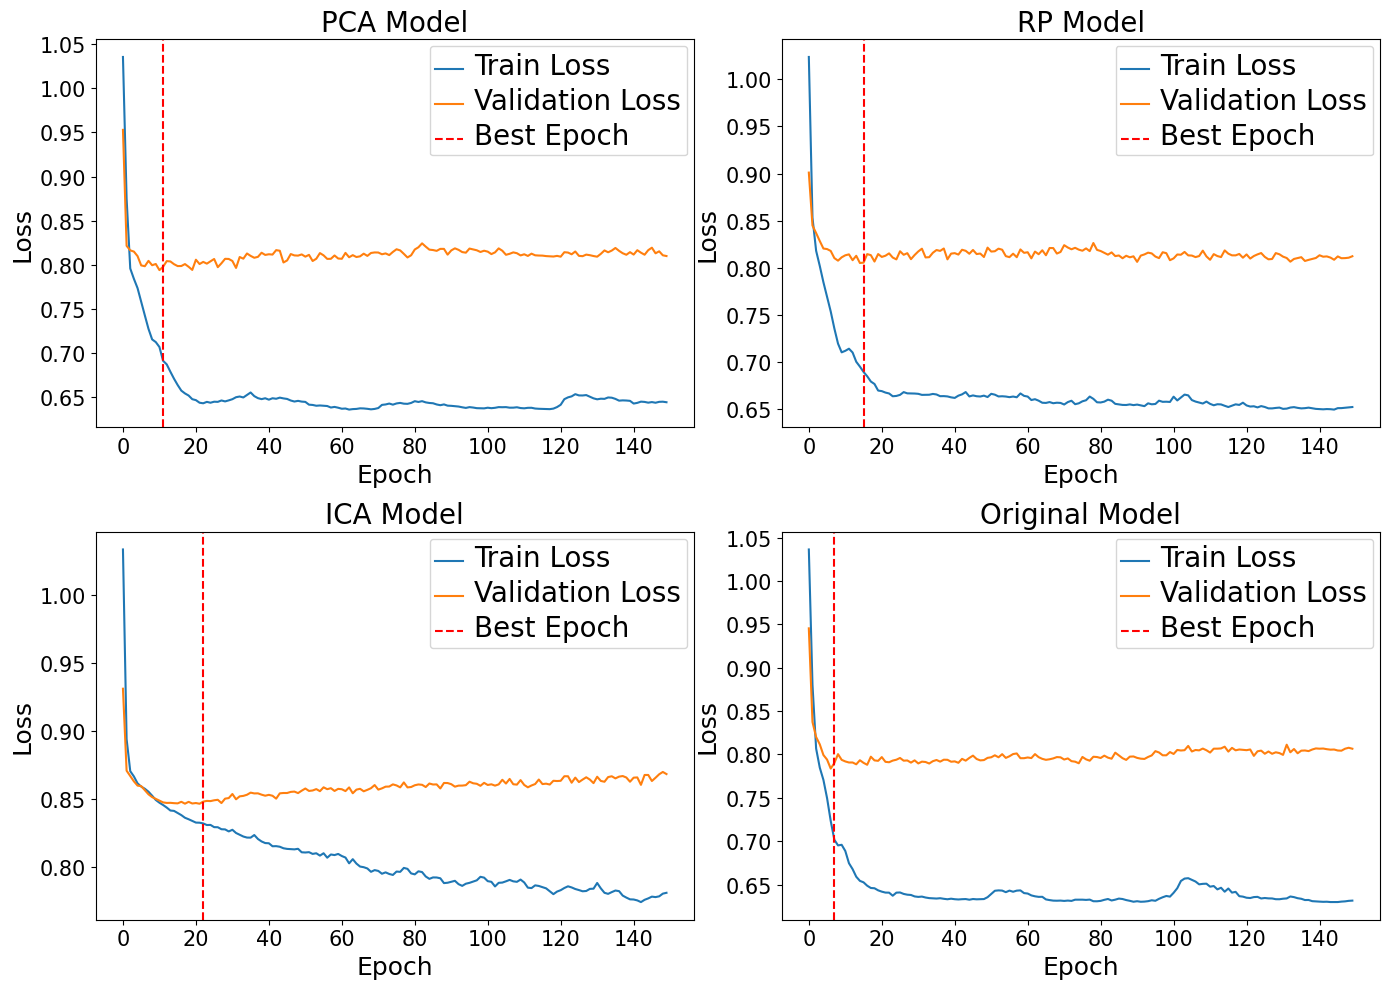

{'PCA': 11, 'RP': 15, 'ICA': 22, 'Original': 7}


In [ ]:
# Plot the loss curves in subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# PCA subplot
axs[0, 0].plot(avg_train_loss_pca, label='Train Loss')
axs[0, 0].plot(avg_val_loss_pca, label='Validation Loss')
axs[0, 0].axvline(x=best_epoch_pca, color='r', linestyle='--', label='Best Epoch')
axs[0, 0].set_title('PCA Model')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].legend()

# RP subplot
axs[0, 1].plot(avg_train_loss_rp, label='Train Loss')
axs[0, 1].plot(avg_val_loss_rp, label='Validation Loss')
axs[0, 1].axvline(x=best_epoch_rp, color='r', linestyle='--', label='Best Epoch')
axs[0, 1].set_title('RP Model')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].legend()

# ICA subplot
axs[1, 0].plot(avg_train_loss_ica, label='Train Loss')
axs[1, 0].plot(avg_val_loss_ica, label='Validation Loss')
axs[1, 0].axvline(x=best_epoch_ica, color='r', linestyle='--', label='Best Epoch')
axs[1, 0].set_title('ICA Model')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Loss')
axs[1, 0].legend()

# Original subplot
axs[1, 1].plot(avg_train_loss_orginal, label='Train Loss')
axs[1, 1].plot(avg_val_loss_orginal, label='Validation Loss')
axs[1, 1].axvline(x=best_epoch_orginal, color='r', linestyle='--', label='Best Epoch')
axs[1, 1].set_title('Original Model')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Loss')
axs[1, 1].legend()
helpers.increase_font_size_subplots_included(plt)
plt.tight_layout()
plt.show()

best_epochs = {
    'PCA': best_epoch_pca,
    'RP': best_epoch_rp,
    'ICA': best_epoch_ica,
    'Original': best_epoch_orginal
}


print(best_epochs)

### reparameterize NN pipeliens with best epoch

In [ ]:
best_net_inputs_sdas["max_epochs"] = best_epoch_pca
best_net_inputs_sdas["module__input_dim"] = 154
net_pipeline_pca = pipelines.NN_pipeline(X_train_sdas,CATEGORY_COLUMNS_UCML,  pipeline_PCA_sdas,**best_net_inputs_sdas)
# adjust for RP
best_net_inputs_sdas["module__input_dim"] = 186
best_net_inputs_sdas["max_epochs"] = best_epoch_rp
net_pipeline_rp = pipelines.NN_pipeline(X_train_sdas,CATEGORY_COLUMNS_UCML,  pipeline_RP_sdas,**best_net_inputs_sdas)

# adjust for ICA
best_net_inputs_sdas["module__input_dim"] = 6
best_net_inputs_sdas["max_epochs"] = best_epoch_ica
net_pipeline_ica = pipelines.NN_pipeline(X_train_sdas,CATEGORY_COLUMNS_UCML,  pipeline_ICA_sdas,**best_net_inputs_sdas)

# adjust for original
best_net_inputs_sdas["module__input_dim"] = 200
best_net_inputs_sdas["max_epochs"] = best_epoch_orginal
net_pipeline_orginal = pipelines.NN_pipeline(X_train_sdas,CATEGORY_COLUMNS_UCML,  None,**best_net_inputs_sdas)

cpu
cpu
cpu
cpu


In [ ]:
reload_notebook_cell()
# perform cross validation
scores_pca = cross_validate( 
               net_pipeline_pca, 
               X_train_sdas, 
               y_train_encode_sdas, 
               cv=cv, 
               return_train_score=True, 
               scoring={'accuracy': make_scorer(accuracy_score), 
         'f1': make_scorer(f1_score, average='macro')},
               
               n_jobs=1)

scores_rp = cross_validate( 
                net_pipeline_rp, 
                X_train_sdas, 
                y_train_encode_sdas, 
                cv=cv, 
                return_train_score=True, 
                scoring={'accuracy': make_scorer(accuracy_score), 
         'f1': make_scorer(f1_score, average='macro')}
        ,  n_jobs=1)

scores_ica = cross_validate(
                net_pipeline_ica, 
                X_train_sdas, 
                y_train_encode_sdas, 
                cv=cv, 
                return_train_score=True, 
                  scoring={'accuracy': make_scorer(accuracy_score), 
         'f1': make_scorer(f1_score, average='macro'),
               },  n_jobs=1)
scores_orginal = cross_validate(
                net_pipeline_orginal, 
                X_train_sdas, 
                y_train_encode_sdas, 
                cv=cv, 
                return_train_score=True, 
                  scoring={'accuracy': make_scorer(accuracy_score), 
         'f1': make_scorer(f1_score, average='macro')
               })

In [ ]:
## add best train/val loss and best train/val epochs to scores
scores_pca['best_train_loss'] = best_train_loss_pca
scores_pca['best_val_loss'] = best_val_loss_pca
scores_pca['best_train_epoch'] = best_train_epoch_pca
scores_pca['best_val_epoch'] = best_epoch_pca

scores_rp['best_train_loss'] = best_train_loss_rp
scores_rp['best_val_loss'] = best_val_loss_rp
scores_rp['best_train_epoch'] = best_train_epoch_rp
scores_rp['best_val_epoch'] = best_epoch_rp

scores_ica['best_train_loss'] = best_train_loss_ica
scores_ica['best_val_loss'] = best_val_loss_ica
scores_ica['best_train_epoch'] = best_train_epoch_ica
scores_ica['best_val_epoch'] = best_epoch_ica

scores_orginal['best_train_loss'] = best_train_loss_orginal
scores_orginal['best_val_loss'] = best_val_loss_orginal
scores_orginal['best_train_epoch'] = best_train_epoch_orginal
scores_orginal['best_val_epoch'] = best_epoch_orginal


scores_orginal

{'fit_time': array([0.90902328, 0.98406696, 1.04906178, 0.82386732]),
 'score_time': array([0.03199935, 0.04700637, 0.03774667, 0.03199744]),
 'test_accuracy': array([0.73446328, 0.71638418, 0.7480226 , 0.76244344]),
 'train_accuracy': array([0.8089676 , 0.8236624 , 0.81876413, 0.83276836]),
 'test_f1': array([0.61200703, 0.61355339, 0.63596246, 0.67058875]),
 'train_f1': array([0.71523446, 0.73916302, 0.73631579, 0.77987567]),
 'best_train_loss': 0.7234141139498927,
 'best_val_loss': 0.7837557992187597,
 'best_train_epoch': 7,
 'best_val_epoch': 7}

In [ ]:
import pandas as pd
# Example cross-validation results dictionaries for other methods


# Convert to DataFrames
df_scores_rp = pd.DataFrame(scores_rp)
df_scores_ica = pd.DataFrame(scores_ica)
df_scores_orginal = pd.DataFrame(scores_orginal)
df_scores_pca = pd.DataFrame(scores_pca)
# Rename columns
df_scores_rp.rename(columns={'test_log_loss': 'validation_log_loss'}, inplace=True)
df_scores_ica.rename(columns={'test_log_loss': 'validation_log_loss'}, inplace=True)
df_scores_orginal.rename(columns={'test_log_loss': 'validation_log_loss'}, inplace=True)
df_scores_pca.rename(columns={ 'test_log_loss': 'validation_log_loss'}, inplace=True)
# Rename test_f1 to validation_f1
df_scores_rp.rename(columns={'test_f1': 'validation_f1'}, inplace=True)
df_scores_ica.rename(columns={'test_f1': 'validation_f1'}, inplace=True)
df_scores_orginal.rename(columns={'test_f1': 'validation_f1'}, inplace=True)
df_scores_pca.rename(columns={'test_f1': 'validation_f1'}, inplace=True)


# Drop F1 columns
# df_scores_rp.drop(columns=['test_f1', 'train_f1'], inplace=True)
# df_scores_ica.drop(columns=['test_f1', 'train_f1'], inplace=True)
# df_scores_orginal.drop(columns=['test_f1', 'train_f1'], inplace=True)
# df_scores_pca.drop(columns=['test_f1', 'train_f1'], inplace=True)

# Add method names
df_scores_pca['method'] = 'PCA'
df_scores_rp['method'] = 'RP'
df_scores_ica['method'] = 'ICA'
df_scores_orginal['method'] = 'Original'

# Combine all DataFrames
df_all_scores = pd.concat([df_scores_pca, df_scores_rp, df_scores_ica, df_scores_orginal], ignore_index=True)
df_avg_scores = df_all_scores.groupby('method').mean().reset_index()
df_avg_scores

,method,fit_time,score_time,test_accuracy,train_accuracy,validation_f1,train_f1,best_train_loss,best_val_loss,best_train_epoch,best_val_epoch
0,ICA,3.697831,0.037661,0.686637,0.711784,0.571443,0.602477,0.832762,0.846664,22.0,22.0
1,Original,0.941505,0.037187,0.740328,0.821041,0.633028,0.742647,0.723414,0.783756,7.0,7.0
2,PCA,1.489892,0.043581,0.733824,0.850147,0.649272,0.801958,0.706330,0.793652,11.0,11.0
3,RP,1.889776,0.041194,0.727609,0.845059,0.647077,0.802505,0.694993,0.805017,15.0,15.0


## See How each model performs on the test set

In [ ]:
reload_notebook_cell()
best_net_inputs_sdas["max_epochs"] = best_epoch_pca
best_net_inputs_sdas["module__input_dim"] = 154
net_pipeline_pca = pipelines.NN_pipeline(X_train_sdas,CATEGORY_COLUMNS_UCML,  pipeline_PCA_sdas,**best_net_inputs_sdas)
# adjust for RP
best_net_inputs_sdas["module__input_dim"] = 186
best_net_inputs_sdas["max_epochs"] = best_epoch_rp
net_pipeline_rp = pipelines.NN_pipeline(X_train_sdas,CATEGORY_COLUMNS_UCML,  pipeline_RP_sdas,**best_net_inputs_sdas)

# adjust for ICA
best_net_inputs_sdas["module__input_dim"] = 6
best_net_inputs_sdas["max_epochs"] = best_epoch_ica
net_pipeline_ica = pipelines.NN_pipeline(X_train_sdas,CATEGORY_COLUMNS_UCML,  pipeline_ICA_sdas,**best_net_inputs_sdas)

# adjust for original
best_net_inputs_sdas["module__input_dim"] = 200
best_net_inputs_sdas["max_epochs"] = best_epoch_orginal
net_pipeline_orginal = pipelines.NN_pipeline(X_train_sdas,CATEGORY_COLUMNS_UCML,  None,**best_net_inputs_sdas)

cpu
cpu
cpu
cpu


In [ ]:
reload_notebook_cell()
net_pipeline_pca.fit(X_train_sdas, y_train_encode_sdas)
net_pipeline_rp.fit(X_train_sdas, y_train_encode_sdas)
net_pipeline_ica.fit(X_train_sdas, y_train_encode_sdas)
net_pipeline_orginal.fit(X_train_sdas, y_train_encode_sdas)

NN(steps=[('preprocessor',
           ColumnTransformer(remainder='passthrough',
                             transformers=[('num', StandardScaler(),
                                            ['remainder__Curricular units 1st '
                                             'sem (approved)',
                                             "encoding__Father's "
                                             'qualification_3',
                                             'encoding__Course_9500',
                                             "encoding__Father's occupation_7",
                                             'remainder__Curricular units 2nd '
                                             'sem (grade)',
                                             "encoding__Mother's "
                                             'occupation_132',
                                             "encoding__Father's "...
           <class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=CustomBackpropModule(
    (dropout): Dropout(p=0, inplace=False)
    (activation): ReLU()
    (output_activation): Softmax(dim=-1)
    (layers): ModuleList(
      (0): Linear(in_features=200, out_features=80, bias=True)
      (1-2): 2 x Linear(in_features=80, out_features=80, bias=True)
      (3): Linear(in_features=80, out_features=3, bias=True)
    )
  ),
))])

In [ ]:
reload_notebook_cell()
## evaluate accuracy and log loss of the models on test 
y_pred_pca = net_pipeline_pca.predict(X_test_sdas)
y_pred_rp = net_pipeline_rp.predict(X_test_sdas)
y_pred_ica = net_pipeline_ica.predict(X_test_sdas)
y_pred_orginal = net_pipeline_orginal.predict(X_test_sdas)

accuracy_pca = accuracy_score(y_test_encode_sdas, y_pred_pca)
accuracy_rp = accuracy_score(y_test_encode_sdas, y_pred_rp)
accuracy_ica = accuracy_score(y_test_encode_sdas, y_pred_ica)
accuracy_orginal = accuracy_score(y_test_encode_sdas, y_pred_orginal)

log_loss_pca = log_loss(y_test_encode_sdas, net_pipeline_pca.predict_proba(X_test_sdas))
log_loss_rp = log_loss(y_test_encode_sdas, net_pipeline_rp.predict_proba(X_test_sdas))
log_loss_ica = log_loss(y_test_encode_sdas, net_pipeline_ica.predict_proba(X_test_sdas))
log_loss_orginal = log_loss(y_test_encode_sdas, net_pipeline_orginal.predict_proba(X_test_sdas))

print(f'Accuracy PCA: {accuracy_pca:.4f}, Log Loss PCA: {log_loss_pca:.4f}')
print(f'Accuracy RP: {accuracy_rp:.4f}, Log Loss RP: {log_loss_rp:.4f}')
print(f'Accuracy ICA: {accuracy_ica:.4f}, Log Loss ICA: {log_loss_ica:.4f}')
print(f'Accuracy Original: {accuracy_orginal:.4f}, Log Loss Original: {log_loss_orginal:.4f}')

# print f1
f1_pca = f1_score(y_test_encode_sdas, y_pred_pca, average='macro')
f1_rp = f1_score(y_test_encode_sdas, y_pred_rp, average='macro')
f1_ica = f1_score(y_test_encode_sdas, y_pred_ica, average='macro')
f1_orginal = f1_score(y_test_encode_sdas, y_pred_orginal, average='macro')
print(f'F1 PCA: {f1_pca:.4f}')
print(f'F1 RP: {f1_rp:.4f}')
print(f'F1 ICA: {f1_ica:.4f}')
print(f'F1 Original: {f1_orginal:.4f}')

# add to df
df_avg_scores['test_accuracy'] = [accuracy_ica, accuracy_orginal, accuracy_pca, accuracy_rp]
df_avg_scores['test_log_loss'] = [log_loss_ica, log_loss_orginal, log_loss_pca, log_loss_rp]
df_avg_scores['best_epoch'] = [best_epoch_ica, best_epoch_orginal, best_epoch_pca, best_epoch_rp]

#add f1 to df
df_avg_scores['test_f1'] = [f1_ica, f1_orginal, f1_pca, f1_rp]

df_avg_scores

Accuracy PCA: 0.7164, Log Loss PCA: 0.8264
Accuracy RP: 0.7379, Log Loss RP: 0.8075
Accuracy ICA: 0.6667, Log Loss ICA: 0.8695
Accuracy Original: 0.7638, Log Loss Original: 0.7836
F1 PCA: 0.6277
F1 RP: 0.6504
F1 ICA: 0.5426
F1 Original: 0.6679


,method,fit_time,score_time,test_accuracy,train_accuracy,validation_f1,train_f1,best_train_loss,best_val_loss,best_train_epoch,best_val_epoch,test_log_loss,best_epoch,test_f1
0,ICA,3.697831,0.037661,0.666667,0.711784,0.571443,0.602477,0.832762,0.846664,22.0,22.0,0.869451,22,0.542617
1,Original,0.941505,0.037187,0.763842,0.821041,0.633028,0.742647,0.723414,0.783756,7.0,7.0,0.783615,7,0.667915
2,PCA,1.489892,0.043581,0.716384,0.850147,0.649272,0.801958,0.706330,0.793652,11.0,11.0,0.826390,11,0.627729
3,RP,1.889776,0.041194,0.737853,0.845059,0.647077,0.802505,0.694993,0.805017,15.0,15.0,0.807515,15,0.650377
